In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv

import sys
sys.path.append('/Users/oabas/Documents/GitHub/Exercise-Pose-Detection/Codebase/model_training')
from data import BodyPart

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score

import tensorflow as tf
import tensorflowjs as tfjs
from tensorflow import keras

In [3]:
tfjs_model_dir = 'model'

In [4]:
def load_csv(csv_path):
    df = pd.read_csv(csv_path)
    df.drop(['filename'],axis=1, inplace=True)
    classes = df.pop('class_name').unique()
    y = df.pop('class_no')

    X = df.astype('float64')
    y = keras.utils.to_categorical(y)
    
    return X, y, classes


def get_center_point(landmarks, left_bodypart, right_bodypart):
    left = tf.gather(landmarks, left_bodypart.value, axis=1)
    right = tf.gather(landmarks, right_bodypart.value, axis=1)
    center = left * 0.5 + right * 0.5
    return center

In [5]:
def get_pose_size(landmarks, torso_size_multiplier=2.5):
  
    hips_center = get_center_point(landmarks, BodyPart.LEFT_HIP, 
                                 BodyPart.RIGHT_HIP)

    shoulders_center = get_center_point(landmarks, BodyPart.LEFT_SHOULDER,
                                      BodyPart.RIGHT_SHOULDER)

    # Torso size as the minimum body size
    torso_size = tf.linalg.norm(shoulders_center - hips_center)
    # Pose center
    pose_center_new = get_center_point(landmarks, BodyPart.LEFT_HIP, 
                                     BodyPart.RIGHT_HIP)
    pose_center_new = tf.expand_dims(pose_center_new, axis=1)
    # Broadcast the pose center to the same size as the landmark vector to
    # perform substraction
    pose_center_new = tf.broadcast_to(pose_center_new,
                                    [tf.size(landmarks) // (17*2), 17, 2])

    # Dist to pose center
    d = tf.gather(landmarks - pose_center_new, 0, axis=0,
                name="dist_to_pose_center")
    # Max dist to pose center
    max_dist = tf.reduce_max(tf.linalg.norm(d, axis=0))

    # Normalize scale
    pose_size = tf.maximum(torso_size * torso_size_multiplier, max_dist)
    return pose_size

In [6]:
def normalize_pose_landmarks(landmarks):
    """Normalizes the landmarks translation by moving the pose center to (0,0) and
    scaling it to a constant pose size.
  """
  # Move landmarks so that the pose center becomes (0,0)
    pose_center = get_center_point(landmarks, BodyPart.LEFT_HIP, 
                                 BodyPart.RIGHT_HIP)

    pose_center = tf.expand_dims(pose_center, axis=1)
    # Broadcast the pose center to the same size as the landmark vector to perform
    # substraction
    pose_center = tf.broadcast_to(pose_center, 
                                [tf.size(landmarks) // (17*2), 17, 2])
    landmarks = landmarks - pose_center

    # Scale the landmarks to a constant pose size
    pose_size = get_pose_size(landmarks)
    landmarks /= pose_size
    return landmarks

In [7]:
def landmarks_to_embedding(landmarks_and_scores):
    """Converts the input landmarks into a pose embedding."""
    # Reshape the flat input into a matrix with shape=(17, 3)
    reshaped_inputs = keras.layers.Reshape((17, 3))(landmarks_and_scores)

    # Normalize landmarks 2D
    landmarks = normalize_pose_landmarks(reshaped_inputs[:, :, :2])
    # Flatten the normalized landmark coordinates into a vector
    embedding = keras.layers.Flatten()(landmarks)
    return embedding

In [8]:
def preprocess_data(X_train):
    processed_X_train = []
    for i in range(X_train.shape[0]):
        embedding = landmarks_to_embedding(tf.reshape(tf.convert_to_tensor(X_train.iloc[i]), (1, 51)))
        processed_X_train.append(tf.reshape(embedding, (34)))
    return tf.convert_to_tensor(processed_X_train)

In [9]:
X, y, class_names = load_csv('../../../Data/model_data/train_data.csv')
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15)
X_test, y_test, _ = load_csv('../../../Data/model_data/test_data.csv')
num_classes = len(class_names)

In [10]:
processed_X_train = preprocess_data(X_train)
processed_X_val =  preprocess_data(X_val)
processed_X_test = preprocess_data(X_test)

Metal device set to: Apple M2

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



In [11]:
print("Shape of processed_X_train:", processed_X_train.shape)
print("Shape of processed_X_val:", processed_X_val.shape)
print("Shape of processed_X_test:", processed_X_test.shape)

Shape of processed_X_train: (5357, 34)
Shape of processed_X_val: (946, 34)
Shape of processed_X_test: (1303, 34)


In [12]:
print("Shape of y_train:", y_train.shape)
print("Shape of y_val:", y_val.shape)
print("Shape of y_test:", y_test.shape)

Shape of y_train: (5357, 13)
Shape of y_val: (946, 13)
Shape of y_test: (1303, 13)


In [13]:
# DNN model
inputs = keras.Input(shape=(34,)) 

# Hidden layers
layer = keras.layers.Dense(128, activation=tf.nn.relu6)(inputs)
layer = keras.layers.Dropout(0.5)(layer)
layer = keras.layers.Dense(64, activation=tf.nn.relu6)(layer)
layer = keras.layers.Dropout(0.5)(layer)

# Output layer
outputs = keras.layers.Dense(num_classes, activation='softmax')(layer)

In [14]:
model = keras.Model(inputs, outputs)

# Compile
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [15]:
# Add a checkpoint callback to store the checkpoint that has the highest validation accuracy.
checkpoint_path = "mobilenet_1_0_224_tf.h5"
checkpoint = keras.callbacks.ModelCheckpoint(checkpoint_path,
                                             monitor='val_accuracy',
                                             verbose=1,
                                             save_best_only=True,
                                             mode='max')
earlystopping = keras.callbacks.EarlyStopping(monitor='val_accuracy', 
                                              patience=20)

In [16]:
# Start training
print('--------------TRAINING----------------')
history = model.fit(processed_X_train, y_train,
                    epochs=150,
                    batch_size=16,
                    validation_data=(processed_X_val, y_val),
                    callbacks=[checkpoint, earlystopping])

print('-----------------EVAUATION----------------')
loss, accuracy = model.evaluate(processed_X_test, y_test)
print('LOSS: ', loss)
print("ACCURACY: ", accuracy)

--------------TRAINING----------------
Epoch 1/150
335/335 [==============================] - ETA: 0s - loss: 1.5150 - accuracy: 0.5292
Epoch 1: val_accuracy improved from -inf to 0.69450, saving model to mobilenet_1_0_224_tf.h5
335/335 [==============================] - 5s 15ms/step - loss: 1.5150 - accuracy: 0.5292 - val_loss: 0.9535 - val_accuracy: 0.6945
Epoch 2/150
  9/335 [..............................] - ETA: 4s - loss: 1.0414 - accuracy: 0.6736

/Users/oabas/miniconda3/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


332/335 [============================>.] - ETA: 0s - loss: 0.8581 - accuracy: 0.7076
Epoch 2: val_accuracy improved from 0.69450 to 0.76110, saving model to mobilenet_1_0_224_tf.h5
335/335 [==============================] - 5s 14ms/step - loss: 0.8546 - accuracy: 0.7090 - val_loss: 0.7025 - val_accuracy: 0.7611
Epoch 3/150
333/335 [============================>.] - ETA: 0s - loss: 0.6543 - accuracy: 0.7695
Epoch 3: val_accuracy improved from 0.76110 to 0.78436, saving model to mobilenet_1_0_224_tf.h5
335/335 [==============================] - 5s 14ms/step - loss: 0.6539 - accuracy: 0.7700 - val_loss: 0.5977 - val_accuracy: 0.7844
Epoch 4/150
332/335 [============================>.] - ETA: 0s - loss: 0.5462 - accuracy: 0.8072
Epoch 4: val_accuracy improved from 0.78436 to 0.82664, saving model to mobilenet_1_0_224_tf.h5
335/335 [==============================] - 5s 14ms/step - loss: 0.5459 - accuracy: 0.8074 - val_loss: 0.5036 - val_accuracy: 0.8266
Epoch 5/150
334/335 [================

In [18]:
# Make predictions on test data
y_pred = model.predict(processed_X_test)
# Convert predictions to labels
y_pred = tf.argmax(y_pred, axis=1).numpy()

# Calculate precision, recall, and f1-score
precision = precision_score(tf.argmax(y_test, axis=1).numpy(), y_pred, average='weighted')
recall = recall_score(tf.argmax(y_test, axis=1).numpy(), y_pred, average='weighted')
f1 = f1_score(tf.argmax(y_test, axis=1).numpy(), y_pred, average='weighted')

print('PRECISION: ', precision)
print('RECALL: ', recall)
print('F1-SCORE: ', f1)

41/41 [==============================] - 1s 4ms/step
PRECISION:  0.9780787411996839
RECALL:  0.9785111281657713
F1-SCORE:  0.977741981451747


/Users/oabas/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [19]:
# Get the accuracy and validation accuracy from the history object
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Get the loss and validation loss from the history object
loss = history.history['loss']
val_loss = history.history['val_loss']

In [ ]:
# Save the loss, accuracy, and validation accuracy as a CSV file
data = {
    'Accuracy': acc,
    'Val Accuracy': val_acc,
    'Loss': loss,
    'Val Loss': val_loss
}
df = pd.DataFrame(data)
df.to_csv('model_performance.csv', index=False)

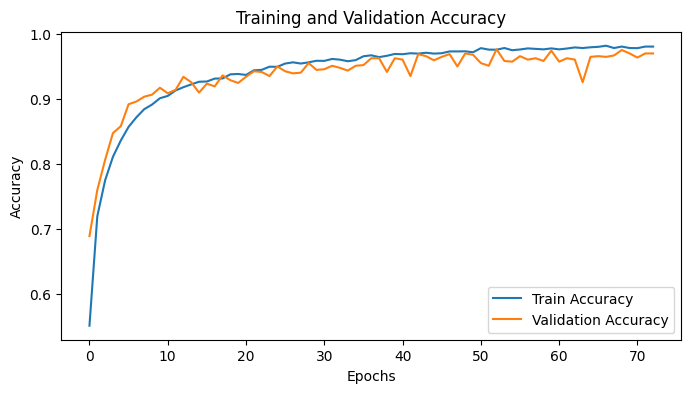

In [ ]:
# Plot the accuracy
plt.figure(figsize=(8, 4))
plt.plot(range(len(acc)), acc, label='Train Accuracy')
plt.plot(range(len(val_acc)), val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
# plt.savefig('accuracy_plot.jpg')
plt.show()

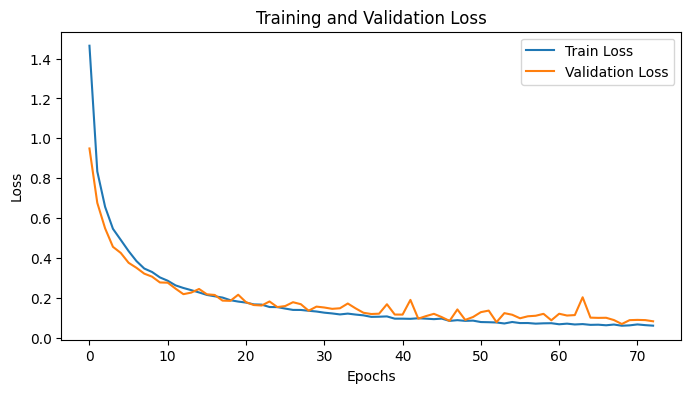

In [ ]:
# Plot the loss
plt.figure(figsize=(8, 4))
plt.plot(range(len(loss)), loss, label='Train Loss')
plt.plot(range(len(val_loss)), val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
# plt.savefig('loss_plot.jpg')
plt.show()

In [ ]:
# Save the model as a SavedModel
tfjs.converters.save_keras_model(model, tfjs_model_dir)
print('tfjs model saved at ',tfjs_model_dir)

tfjs model saved at  model


/Users/oabas/miniconda3/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
